# 关注公众号【Python读财】，选择“星标”公众号，重磅干货，第一时间送达

![](https://upload-images.jianshu.io/upload_images/8316927-0fb816f497f6e7f5.png?imageMogr2/auto-orient/strip%7CimageView2/2/w/1240)

In [3]:
import tushare as ts
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white',{'font.sans-serif':['simhei','Arial']})
plt.rcParams['axes.unicode_minus'] = False 

# 数据准备与处理

## Tushare获取
具体使用方法网址：https://tushare.pro/register?reg=134799

In [2]:
pro = ts.pro_api()

In [3]:
df = pro.cb_basic(fields = 'ts_code,stk_code,list_date')

In [4]:
data = df[(df.list_date>="2018-01-01") & (df.list_date<"2020-01-01")]

In [5]:
basic_df = pro.stock_basic(exchange='', list_status='L', fields='ts_code,industry,market')
data = data.merge(basic_df,left_on="stk_code",right_on="ts_code",how="left")
data.drop(columns="ts_code_y",inplace=True)
data.rename(columns={"ts_code_x":'ts_code'},inplace=True)
data.dropna(how="any",inplace=True)

In [6]:
def get_mv_and_profit(x):
    ts_code = x["ts_code"]
    date = x["list_date"].replace("-","")
    x["total_mv"] = pro.daily_basic(ts_code=x["stk_code"],trade_date =date)["total_mv"][0]
    x['profit'] = (pro.cb_daily(ts_code=ts_code,trade_date=date)["open"][0]-100)/100
    return x

In [ ]:
new_data = data.apply(get_mv_and_profit,axis=1)
data = new_data.reset_index(drop=True)
data["year"] = data["list_date"].str.split("-").map(lambda x:x[0])
data["month"] = data["list_date"].str.split("-").map(lambda x:int(x[1]))
data["total_mv"] = data["total_mv"]/1e4

## 数据导入

In [4]:
data = pd.read_csv("./data/daxin.csv",index_col = 0)

## 收益率分析

Text(0.02, 2, '峰值=1.5%')

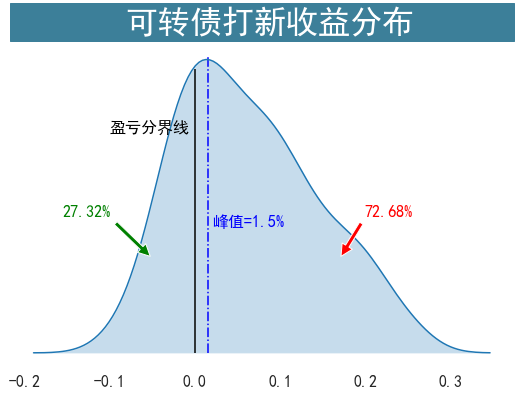

In [12]:
lose_size = round((data.profit<=0).mean(),4)*100
win_size = round((data.profit>0).mean(),4)*100
median = data.profit.median()
fig,ax = plt.subplots(figsize=(9,6))
fig.text(x=0.13, y=0.90, s='       可转债打新收益分布      ', 
         fontsize=32, weight='bold', color='white', backgroundcolor='#3c7f99')
sns.kdeplot(data.profit,shade=True,legend=False,ax=ax)
plt.vlines(0,0,4.5,colors="black")
plt.vlines(0.015,0,4.7,linestyles='dashdot',colors="b")

plt.box(False)
plt.yticks([])
plt.tick_params(axis='both', which='major', labelsize=16,bottom=False)
ax.annotate('{}%'.format(lose_size), (-0.05, 1.5),
            xytext=(0.2,0.5), textcoords='axes fraction',
            arrowprops=dict(facecolor='g', shrink=0.05),
            fontsize=16,color = "g",
            horizontalalignment='right', verticalalignment='top')
ax.annotate('{}%'.format(win_size), (0.17, 1.5),
            xytext=(0.8,0.5), textcoords='axes fraction',
            arrowprops=dict(facecolor='r', shrink=0.05),
            fontsize=16,color = "r",
            horizontalalignment='right', verticalalignment='top')
ax.annotate('盈亏分界线', (0, 1.5),
            xytext=(-0.1,3.5), textcoords='data',
            fontsize=16,color = "black",)
ax.annotate('峰值=1.5%', (0.02, 1.5),
            xytext=(0.02,2), textcoords='data',
            fontsize=16,color = "b",)

## 公司市值与收益率关系

Text(0, 0.5, '收益率')

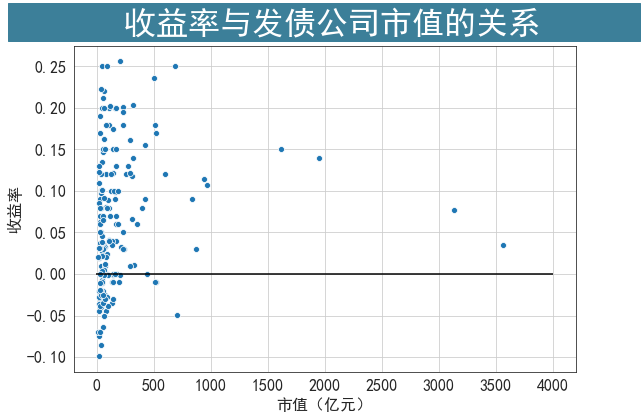

In [13]:
fig,ax = plt.subplots(figsize=(9,6))
fig.text(x=0.03, y=0.91, s='       收益率与发债公司市值的关系      ', 
         fontsize=32, weight='bold', color='white', backgroundcolor='#3c7f99')
sns.scatterplot(x = "total_mv", y ="profit",data=data)
plt.hlines(0,xmin=-1,xmax=4000,colors="black")
plt.tick_params(axis='both', which='major', labelsize=16,bottom=False)
plt.grid()
plt.xlabel("市值（亿元）",fontdict={"size":16})
plt.ylabel("收益率",fontdict={"size":16})

Text(0, 0.5, '收益率')

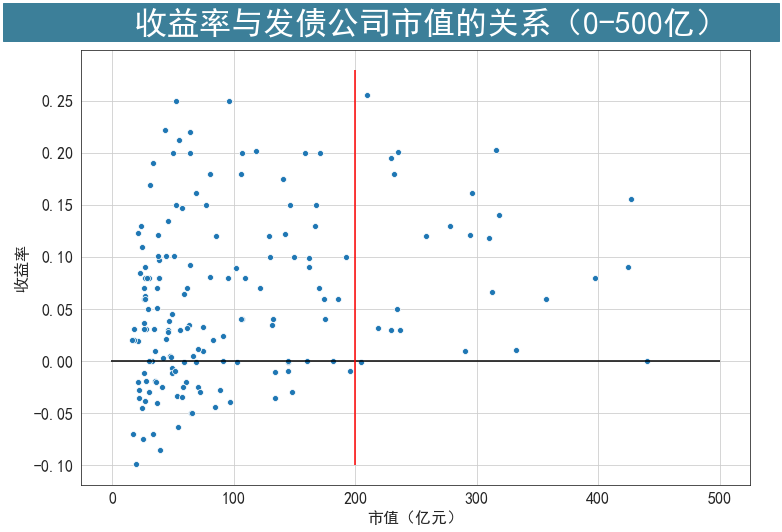

In [14]:
fig,ax = plt.subplots(figsize=(12,8))
fig.text(x=0.04, y=0.91, s='        收益率与发债公司市值的关系（0-500亿）   ', 
         fontsize=32, weight='bold', color='white', backgroundcolor='#3c7f99')
sns.scatterplot(x = "total_mv", y ="profit",data=data[data["total_mv"]<=500])
plt.hlines(0,xmin=-1,xmax=500,colors="black")
plt.vlines(200,ymin=-0.1,ymax=0.28,colors="r")
plt.tick_params(axis='both', which='major', labelsize=16,bottom=False)
plt.grid()
plt.xlabel("市值（亿元）",fontdict={"size":16})
plt.ylabel("收益率",fontdict={"size":16})

## 板块与收益率的关系

Text(0, 0.5, '所处板块')

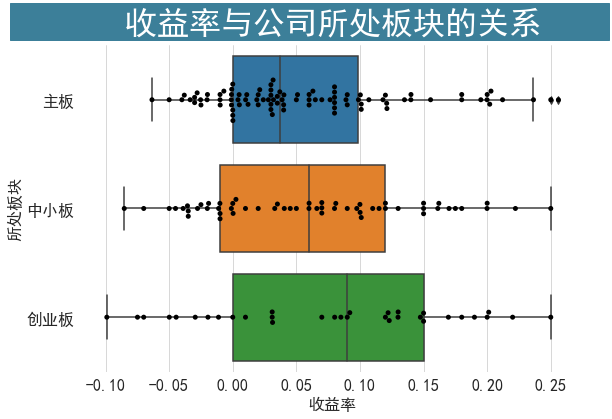

In [15]:
fig,ax = plt.subplots(figsize=(9,6))
fig.text(x=0.02, y=0.91, s='       收益率与公司所处板块的关系    ', 
         fontsize=32, weight='bold', color='white', backgroundcolor='#3c7f99')
sns.boxplot(x = "profit",y = "market",data=data,order=["主板","中小板","创业板"])
sns.swarmplot(x = "profit",y = "market",data=data,order=["主板","中小板","创业板"],color="black")
plt.tick_params(axis="both",labelsize=16)
ax.xaxis.grid(which='both', linewidth=0.75)
plt.box(False)
plt.xlabel('收益率', fontsize=16)
plt.ylabel('所处板块', fontsize=16)

## 行业与收益率的关系

In [16]:
industry = [industry for industry,df in list(data.groupby("industry")) if len(df)>=5]
industry_df = data[data.industry.isin(industry)]

Text(0, 0.5, '')

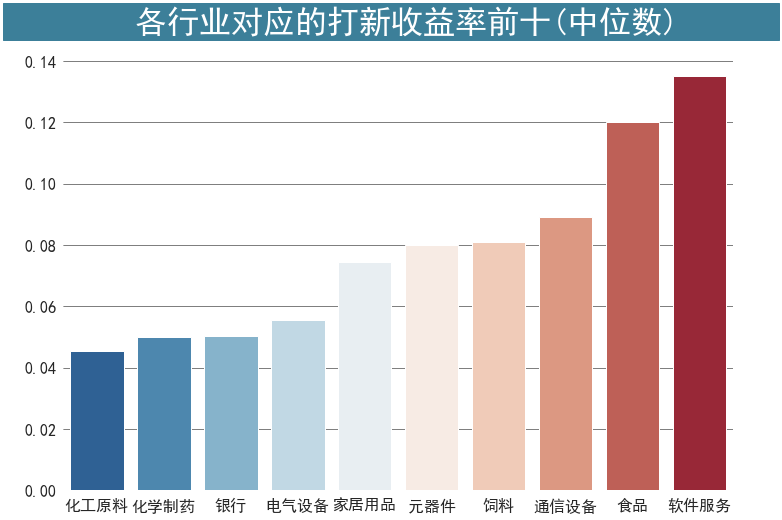

In [17]:
fig,ax = plt.subplots(figsize=(12,8))
fig.text(x=0.06, y=0.92, s='        各行业对应的打新收益率前十(中位数)      ', 
         fontsize=32, weight='bold', color='white', backgroundcolor='#3c7f99')
industry_order = industry_df.groupby("industry")["profit"].median()\
               .sort_values()\
               .index.tolist()[2:]
sns.barplot(x="industry", y="profit", order=industry_order, data=industry_df, estimator = np.median,ci = None,palette="RdBu_r")

plt.tick_params(axis="both",labelsize=16,)
ax.yaxis.grid(which='both', linewidth=0.5, color='black')
plt.box(False)
plt.xlabel('')
plt.ylabel('')

## 时间效应

In [18]:
heatmap_df = data.groupby("month")["profit"].describe().sort_index().drop(columns = "count")

In [19]:
heatmap_df

,mean,std,min,25%,50%,75%,max
month,,,,,,,
1,0.057034,0.071953,-0.04990,0.001875,0.03765,0.08750,0.25000
2,0.068483,0.055029,-0.01010,0.042750,0.06150,0.10650,0.14000
3,0.113747,0.068556,-0.00120,0.076500,0.11810,0.15000,0.22220
4,0.103216,0.083288,-0.03500,0.045450,0.09000,0.16000,0.25600
5,0.014708,0.071331,-0.05000,-0.026475,-0.00605,0.03500,0.19989
6,0.000550,0.079578,-0.08530,-0.046450,-0.00675,0.04025,0.10100
7,0.050289,0.074501,-0.04000,-0.009250,0.02560,0.11300,0.20200
8,-0.024560,0.038839,-0.09900,-0.054250,-0.01950,0.00210,0.03880
9,0.089345,0.103328,-0.07000,0.003095,0.11000,0.16535,0.23640


(Text(0.5, 53.0, ''), Text(71.0, 0.5, ''))

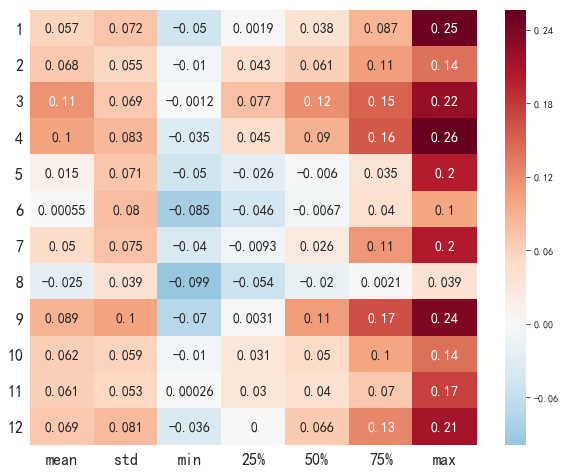

In [20]:
fig,ax = plt.subplots(figsize=(10,8))
sns.heatmap(heatmap_df,cmap="RdBu_r",center=0,annot=True,annot_kws={'fontsize':14})
plt.tick_params(axis='x', which='major', labelsize=16)
plt.tick_params(axis='y', which='major', labelsize=16,labelrotation=0)
plt.xlabel(""),plt.ylabel("")